In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Feature Matching
Till now, we've seen different methods to find keypoints / features in an image, and read about descriptors. Now, we'll discuss about feature matching in two images, and see more clearly how descriptors work.

We'll start with Brute-Force Matcher which takes each feature in set1 and compares it to every feature in set2

<b>`cv2.BFMatcher(, [normType, [crossCheck]])`</b>

1. <u>normType</u> - Distance measurement to be used. By default, it is cv2.NORM_L2 (good for SURF, SIFT). cv2.NORM_HAMMING is good for ORB, BRIEF, BRISK etc.
2. <u>crossCheck</u> - A boolean flag, which is False by default. If True, then it only returns match pair (i, j) only if i-th descriptor in set1 has j-th descriptor in set2 as best match and vice-versa.

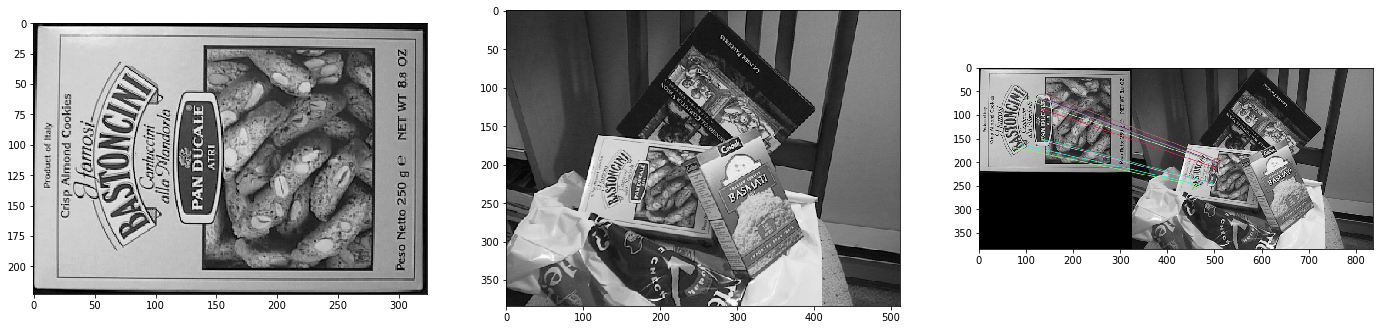

In [2]:
cv2.ocl.setUseOpenCL(False)

image1 = cv2.imread("../resources/box.png", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread("../resources/box_in_scene.png", cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()

kp1 = orb.detect(image1, mask=None)
kp2 = orb.detect(image2, mask=None)
desc1, desc2 = orb.compute(image1, kp1)[1], orb.compute(image2, kp2)[1]

matcher = cv2.BFMatcher(normType=cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)  # can also do matcher.knnMatch(desc1, desc2, k)
matches = sorted(matches, key=lambda x: x.distance)

# matches => DMatch objects (distance, trainIdx, queryIdx, imgIdx)

out = cv2.drawMatches(image1, kp1, image2, kp2, matches[:10], None, flags=2)

fig = plt.figure(); fig.set_size_inches(24, 10)

fig.add_subplot(1, 3, 1); plt.imshow(image1, cmap='gray')
fig.add_subplot(1, 3, 2); plt.imshow(image2, cmap='gray')
fig.add_subplot(1, 3, 3); plt.imshow(out)

plt.show()

# FLANN (Fast Library for Approximate Nearest Neighbours) based Matcher
It contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features. It works more faster than BFMatcher for large datasets.

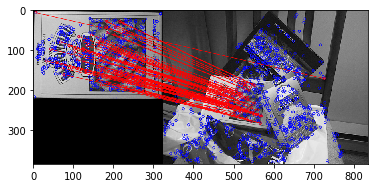

In [3]:
cv2.ocl.setUseOpenCL(False)
# index params for SURF, SIFT...
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# index params for ORB
# index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 12, multi_probe_level = 1)

# search_params = dict(checks = 100) => more checks -> more precision but more time also

sift = cv2.xfeatures2d.SIFT_create()

kp1, desc1 = sift.detectAndCompute(image1, mask=None)
kp2, desc2 = sift.detectAndCompute(image2, mask=None)

dist_ratio = 0.7

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 100)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc1, desc2, k=2)
good_match = [[0, 0] for i in range(len(matches))]

for i, (k1, k2) in enumerate(matches):
    if k1.distance < dist_ratio * k2.distance: good_match[i] = [1, 0]

draw_params = dict(
    matchColor = (255, 0, 0),
    singlePointColor = (0, 0, 255),
    matchesMask = good_match,
    flags = 0
)

out = cv2.drawMatchesKnn(image1, kp1, image2, kp2, matches, None, **draw_params)
plt.imshow(out)
plt.show()

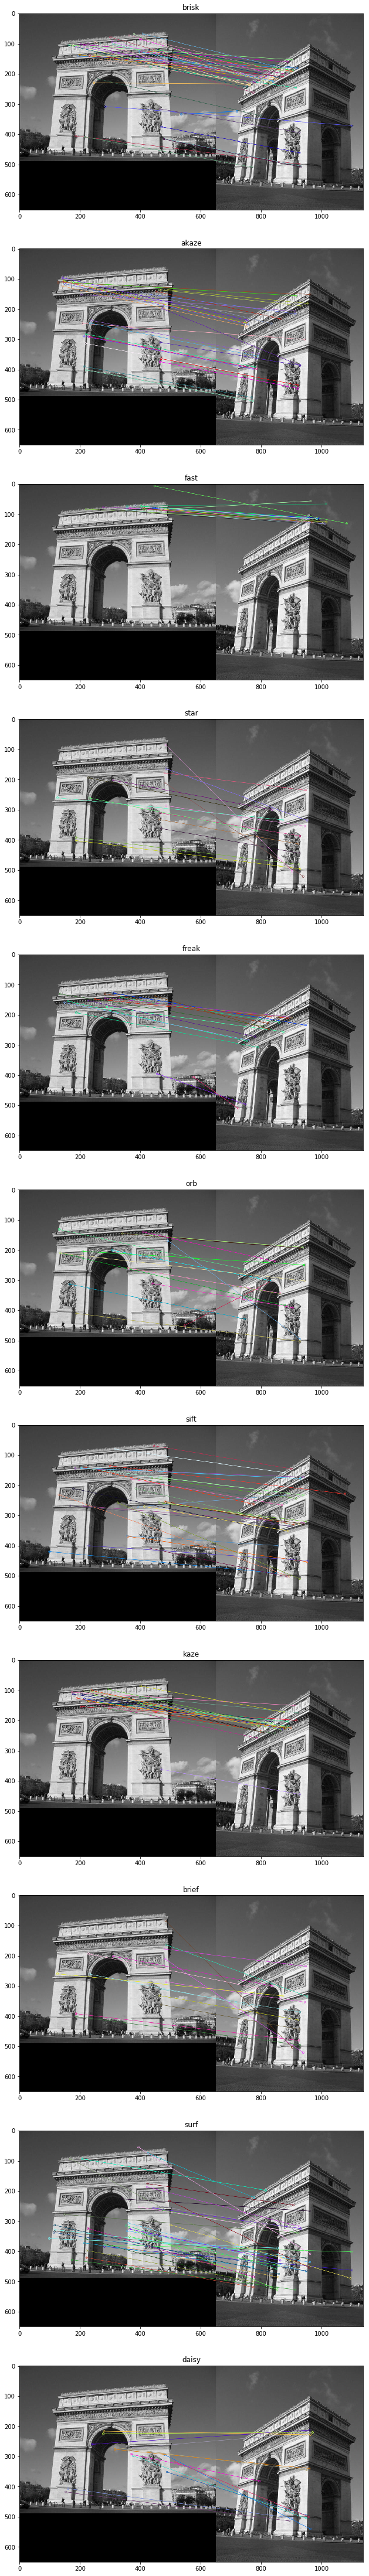

brisk : 44
akaze : 28
fast : 23
star : 14
freak : 15
orb : 15
sift : 30
kaze : 28
brief : 14
surf : 34
daisy : 13


In [4]:
# Comparison

image1 = cv2.imread("../resources/feature_target_test.jpg", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread("../resources/feature_test.jpg", cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()
surf = cv2.xfeatures2d.SURF_create()
fast = cv2.FastFeatureDetector_create(cv2.FAST_FEATURE_DETECTOR_TYPE_9_16)
brisk = cv2.BRISK_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
star = cv2.xfeatures2d.StarDetector_create()
orb = cv2.ORB_create()
daisy = cv2.xfeatures2d.DAISY_create()
freak = cv2.xfeatures2d.FREAK_create()
akaze = cv2.AKAZE_create()
kaze = cv2.KAZE_create()

extractors = {"sift": sift, "surf": surf, "fast": fast, "brisk": brisk, "brief": brief,
     "star": star, "orb": orb, "daisy": daisy, "freak": freak, "akaze": akaze, "kaze": kaze}

kp1_default, kp2_default = star.detect(image1, mask=None), star.detect(image2, mask=None)
desc1_default, desc2_default = brief.compute(image1, kp1_default)[1], brief.compute(image2, kp2_default)[1]

fig = plt.figure()
fig.set_size_inches(80, 80)
idx = 1

for name, obj in extractors.items():
    try:
        kp1, desc1 = obj.detectAndCompute(image1, mask=None)
        kp2, desc2 = obj.detectAndCompute(image2, mask=None)
    except:
        try:
            kp1, kp2 = obj.detect(image1, mask=None), obj.detect(image2, mask=None)
            try: desc1, desc2 = obj.compute(image1, kp1)[1], obj.compute(image2, kp2)[1]
            except: desc1, desc2 = desc1_default, desc2_default
        except:
            kp1, kp2 = kp1_default, kp2_default
            desc1, desc2 = obj.compute(image1, kp1)[1], obj.compute(image2, kp2)[1]
    
    fig.add_subplot(11, 1, idx)
    plt.title(name)
    
    if name == "fast": matcher = cv2.BFMatcher(normType=cv2.NORM_HAMMING, crossCheck=False)
    elif name in ["sift", "surf", "daisy", "kaze"]: matcher = cv2.BFMatcher(normType=cv2.NORM_L2, crossCheck=True)
    else: matcher = cv2.BFMatcher(normType=cv2.NORM_HAMMING, crossCheck=True)
    
    matches = matcher.match(desc1, desc2)
    good_m = sorted(matches, key=lambda x:x.distance)[:int(len(matches) ** 0.5)]
    
    extractors[name] = len(good_m)
        
    out = cv2.drawMatches(image1, kp1, image2, kp2, good_m, None, flags=2)
    plt.imshow(out)
    
    idx += 1
plt.show()

for name, match_count in extractors.items(): print(name, ":", match_count)

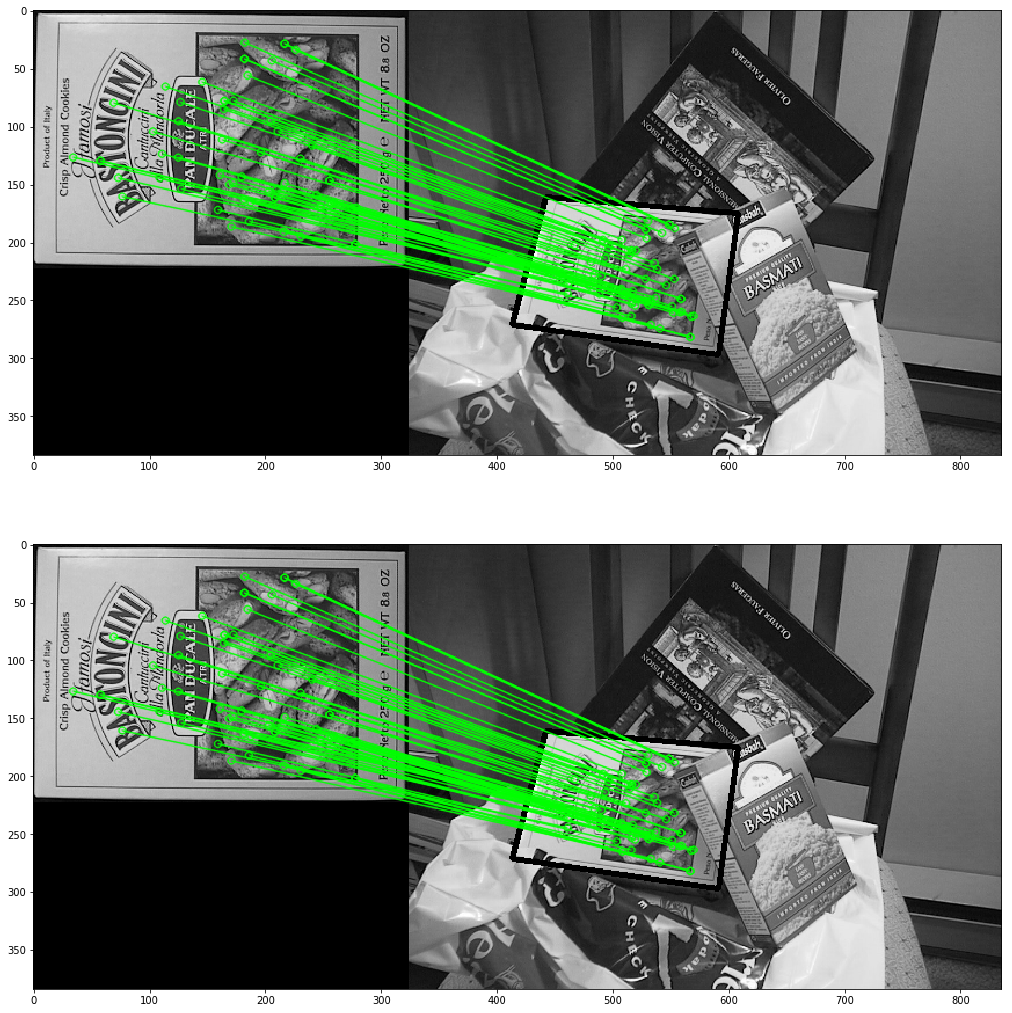

In [21]:
# Homography to find location of object
image1 = cv2.imread("../resources/box.png", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread("../resources/box_in_scene.png", cv2.IMREAD_GRAYSCALE)

kp1, desc1 = sift.detectAndCompute(image1, mask=None)
kp2, desc2 = sift.detectAndCompute(image2, mask=None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 8)
search_params = dict(checks = 100)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(desc1, desc2, k=2)
good_matches = []
for (k1, k2) in matches:
    if k1.distance < 0.6 * k2.distance: good_matches.append(k1)

assert(len(good_matches) > 10)

src_pts = np.float64([kp1[k.queryIdx].pt for k in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float64([kp2[k.trainIdx].pt for k in good_matches]).reshape(-1, 1, 2)

ret1, mask1 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
ret2, mask2 = cv2.findHomography(src_pts, dst_pts, cv2.LMEDS, 5.0)

matchMask1 = mask1.ravel().tolist()
matchMask2 = mask2.ravel().tolist()

h, w = image1.shape
pts = np.float64([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst1 = cv2.perspectiveTransform(pts, ret1)
dst2 = cv2.perspectiveTransform(pts, ret2)

im1 = cv2.polylines(image2, [np.int64(dst1)], True, 0, 3)
im2 = cv2.polylines(image2, [np.int64(dst2)], True, 0, 3)

out1 = cv2.drawMatches(
    image1, kp1, image2, kp2, good_matches, None, flags=2, matchesMask=matchMask1, matchColor=(0, 255, 0)
)
out2 = cv2.drawMatches(
    image1, kp1, image2, kp2, good_matches, None, flags=2, matchesMask=matchMask2, matchColor=(0, 255, 0)
)

fig = plt.figure()
fig.set_size_inches(20, 18)
fig.add_subplot(2, 1, 1)
plt.imshow(out1)
fig.add_subplot(2, 1, 2)
plt.imshow(out2)
plt.show()